In [1]:
# get the environment
import sys
print(sys.version)
print(sys.executable)
import os
os.getcwd()

3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:01:53) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
/Users/Bryan/anaconda/envs/tensorflow2/bin/python


'/Users/Bryan/Documents/DSInfo/TextAnalytics'

In [2]:
# Standard imports
import sys
import warnings
warnings.simplefilter('ignore')
import os
import pandas as pd
import numpy as np


# plotting
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
# improve with plotly
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
print('Seaborn Version: ', sns.__version__)
# get UMAP for dimension reduction
import umap


%matplotlib inline

# for dendograms
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy

# get the lDA algorithm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# text libraries
import nltk
from wordcloud import WordCloud, STOPWORDS# preprocessing prior to lda
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# use the TF-IDF vectorizor to give more weight to rare words
# TF-IDF specific setup
from sklearn.feature_extraction.text import TfidfVectorizer

# set seed for reproducibility
SEED = 42

Seaborn Version:  0.11.1


In [3]:
# TF imports
import tensorflow_hub as hub
import tensorflow as tf

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Load the GUSE model
guse = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")



OSError: SavedModel file does not exist at: /var/folders/ts/8kt91kfx25719qws437qxsp00000gn/T/tfhub_modules/063d866c06683311b44b4992fd46003be952409c/{saved_model.pbtxt|saved_model.pb}

In [6]:
# get the data
data = pd.read_csv('Transactio_4222021_240_PM.csv', low_memory=False)
data.head()

,Respondent Id,Completed Date,Event_Trigger,What best describes your experience?*,Please say more.,OS,DeviceType
0,5885486,04/22/2021 02:19:34 PM,accountsEvent,Not now,NaN,iOS 14.4.2,Phone
1,5885474,04/22/2021 01:58:51 PM,accountsEvent,Not now,NaN,iOS 14.4.2,Phone
2,5885463,04/22/2021 01:45:55 PM,accountsEvent,Had a pretty hard time,This mobile device app is not easy to use. Goi...,Android,Phone
3,5885462,04/22/2021 01:43:08 PM,depositEvent,Not now,NaN,Android,Phone
4,5885457,04/22/2021 01:34:22 PM,transferEvent,Not now,NaN,iOS 14.4.1,Phone


In [7]:
data['Event_Trigger'].value_counts()

accountsEvent    12693
depositEvent      5705
transferEvent     4641
billpayEvent       989
Name: Event_Trigger, dtype: int64

In [8]:
data['OS'].value_counts()

Android       10031
iOS 14.2       5105
iOS 14.3       1985
iOS 14.4       1433
Android 8       532
              ...  
iOS 13.4          1
iOS 10.3.4        1
iOS 12.1.1        1
iOS 12.4.4        1
iOS 13.1.1        1
Name: OS, Length: 65, dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24029 entries, 0 to 24028
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Respondent Id                          24029 non-null  int64 
 1   Completed Date                         24029 non-null  object
 2   Event_Trigger                          24028 non-null  object
 3   What best describes your experience?*  24029 non-null  object
 4   Please say more.                       2667 non-null   object
 5   OS                                     22885 non-null  object
 6   DeviceType                             22885 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


In [10]:
# regroup the OS

def get_os(row):
    if pd.isnull(row):
        return 'None'
    elif "Android" in row:
        return row[0:10]
    else:
        return row[0:7]

In [11]:
data['OS_Group'] = data['OS'].apply(get_os)
data.head(10)

,Respondent Id,Completed Date,Event_Trigger,What best describes your experience?*,Please say more.,OS,DeviceType,OS_Group
0,5885486,04/22/2021 02:19:34 PM,accountsEvent,Not now,NaN,iOS 14.4.2,Phone,iOS 14.
1,5885474,04/22/2021 01:58:51 PM,accountsEvent,Not now,NaN,iOS 14.4.2,Phone,iOS 14.
2,5885463,04/22/2021 01:45:55 PM,accountsEvent,Had a pretty hard time,This mobile device app is not easy to use. Goi...,Android,Phone,Android
3,5885462,04/22/2021 01:43:08 PM,depositEvent,Not now,NaN,Android,Phone,Android
4,5885457,04/22/2021 01:34:22 PM,transferEvent,Not now,NaN,iOS 14.4.1,Phone,iOS 14.
5,5885453,04/22/2021 01:30:09 PM,transferEvent,Not now,NaN,Android,Phone,Android
6,5885451,04/22/2021 01:26:39 PM,accountsEvent,Fast and easy,NaN,iOS 14.4.2,Phone,iOS 14.
7,5885442,04/22/2021 01:20:37 PM,accountsEvent,Fast and easy,NaN,Android,Phone,Android
8,5885430,04/22/2021 01:04:24 PM,depositEvent,Not now,NaN,Android,Phone,Android
9,5885428,04/22/2021 01:03:48 PM,depositEvent,Fast and easy,NaN,NaN,NaN,None


In [12]:
# remove the extra periods
data['OS_Group'] = data['OS_Group'].str.replace('.', '')
data.head(10)

,Respondent Id,Completed Date,Event_Trigger,What best describes your experience?*,Please say more.,OS,DeviceType,OS_Group
0,5885486,04/22/2021 02:19:34 PM,accountsEvent,Not now,NaN,iOS 14.4.2,Phone,iOS 14
1,5885474,04/22/2021 01:58:51 PM,accountsEvent,Not now,NaN,iOS 14.4.2,Phone,iOS 14
2,5885463,04/22/2021 01:45:55 PM,accountsEvent,Had a pretty hard time,This mobile device app is not easy to use. Goi...,Android,Phone,Android
3,5885462,04/22/2021 01:43:08 PM,depositEvent,Not now,NaN,Android,Phone,Android
4,5885457,04/22/2021 01:34:22 PM,transferEvent,Not now,NaN,iOS 14.4.1,Phone,iOS 14
5,5885453,04/22/2021 01:30:09 PM,transferEvent,Not now,NaN,Android,Phone,Android
6,5885451,04/22/2021 01:26:39 PM,accountsEvent,Fast and easy,NaN,iOS 14.4.2,Phone,iOS 14
7,5885442,04/22/2021 01:20:37 PM,accountsEvent,Fast and easy,NaN,Android,Phone,Android
8,5885430,04/22/2021 01:04:24 PM,depositEvent,Not now,NaN,Android,Phone,Android
9,5885428,04/22/2021 01:03:48 PM,depositEvent,Fast and easy,NaN,NaN,NaN,None


In [13]:
data['OS_Group'].value_counts()

iOS 14       10288
Android      10031
None          1144
Android 8      912
iOS 13         691
Android 7      416
iOS 12         375
Android 6       97
Android 5       30
iOS 11          30
iOS 10          15
Name: OS_Group, dtype: int64

In [14]:
text = data[['Please say more.', 'OS_Group']]
text.head()

,Please say more.,OS_Group
0,NaN,iOS 14
1,NaN,iOS 14
2,This mobile device app is not easy to use. Goi...,Android
3,NaN,Android
4,NaN,iOS 14


In [15]:
# rename the colum
text.columns = ["Comments", 'OS']
text.head()

,Comments,OS
0,NaN,iOS 14
1,NaN,iOS 14
2,This mobile device app is not easy to use. Goi...,Android
3,NaN,Android
4,NaN,iOS 14


In [16]:
# lots of NaN only get clean text
df = text[text['Comments'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2667 entries, 2 to 24026
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Comments  2667 non-null   object
 1   OS        2667 non-null   object
dtypes: object(2)
memory usage: 62.5+ KB


# Use a Count Vectorizer for Processing Comments into Bigrams

In [17]:
# max_df - discard words that show up in x percent of documents has a scale 0 - 1
# min_df - is the opposite, minimum frequency can be a percent or raw number of documents
# ngram_range is normally (1,1) for single words, 2,2, for bigrams

cv = CountVectorizer(max_df = 0.95, min_df=2, stop_words='english', ngram_range=(2, 2))

In [18]:
# make document term matrix
dtm = cv.fit_transform(df['Comments'])
dtm

<2667x925 sparse matrix of type '<class 'numpy.int64'>'
	with 3815 stored elements in Compressed Sparse Row format>

In [19]:
dtm.shape

(2667, 925)

In [20]:
# convert to dataframe for clustering
bow = pd.DataFrame(dtm.toarray(), columns = cv.get_feature_names())
bow

,10 10,1st time,20 years,30 minutes,30 years,ability deposit,able access,able balance,able check,able complete,...,works just,works nice,works nicely,works ok,works perfect,works perfectly,works really,write check,year ago,years happy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
bow['OS'] = df['OS']

In [22]:
# collapse it down
osDf = bow.groupby(['OS']).sum()
osDf

,10 10,1st time,20 years,30 minutes,30 years,ability deposit,able access,able balance,able check,able complete,...,works just,works nice,works nicely,works ok,works perfect,works perfectly,works really,write check,year ago,years happy
OS,,,,,,,,,,,,,,,,,,,,,
Android,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Android 7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Android 8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
None,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iOS 12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iOS 13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iOS 14,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [23]:
# Calculate the distance between each sample
Z = linkage(osDf, 'ward')

In [24]:
l = list(osDf.index)
l

['Android', 'Android 7', 'Android 8', 'None', 'iOS 12', 'iOS 13', 'iOS 14']

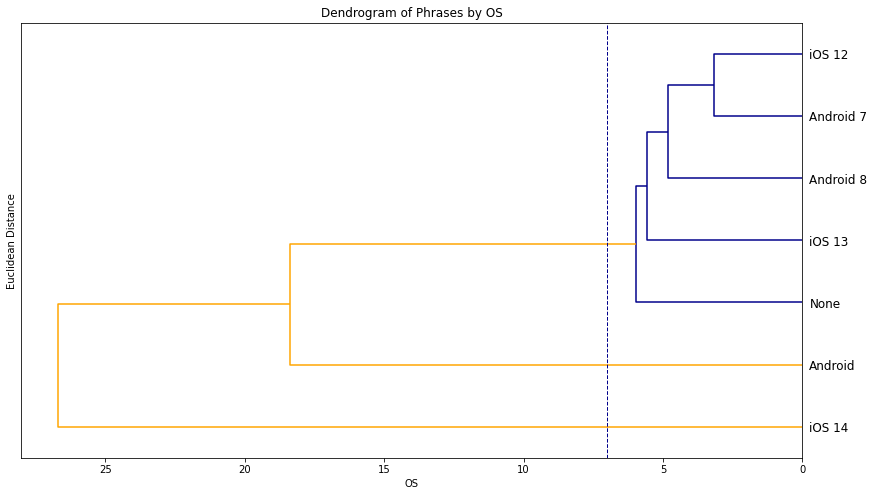

In [25]:
# Make the dendrogram
# # Set the colour of the cluster here: #180A47
# hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
# colors = ["#2A66DE", "#E88202", "#2A66DE", "#E88202"]
hierarchy.set_link_color_palette(["darkblue", 'lightblue']) 

# set the threshold to color
t = 7.0

plt.figure(figsize=(14,8))
dendrogram(Z, labels=l, leaf_rotation=0, leaf_font_size=12,
           orientation="left",
           color_threshold=t,
           above_threshold_color="orange")
plt.axvline(x=t, c='darkblue', lw=1, linestyle='dashed')
plt.title('Dendrogram of Phrases by OS')
plt.xlabel('OS')
plt.ylabel('Euclidean Distance')
plt.show()

# Perform Topic Modeling with LDA


In [26]:
# function to do a grid search of params
def cv_lda(data_in):
    search_params = {'n_components':[4, 6, 8], "learning_decay":[0.3, 0.5, 0.7]}
    
    # initialize model
    LDA = LatentDirichletAllocation(random_state = SEED)
    
    # init grid search class
    model = GridSearchCV(LDA, param_grid = search_params).fit(data_in)
    
    # return best model
    print("Best Model's Params: ", model.best_params_)
    print("\nBest Log Likelihood: ", model.best_score_)
    print("\nBest Perplexity: ", model.best_estimator_.perplexity(data_in))
    model.best_estimator_

In [27]:
model = cv_lda(dtm)

Best Model's Params:  {'learning_decay': 0.3, 'n_components': 4}

Best Log Likelihood:  -7186.6071918438

Best Perplexity:  951.4570983177874


In [28]:
LDA = LatentDirichletAllocation(n_components=4, random_state=SEED, learning_decay=0.3)
LDA.fit(dtm)

LatentDirichletAllocation(learning_decay=0.3, n_components=4, random_state=42)

In [29]:
# grab the vocabulary of words
len(cv.get_feature_names())

925

In [30]:
LDA.components_.shape

(4, 925)

In [31]:
# get one topic
single_topic = LDA.components_[0]

In [32]:
# take a look
top_twenty_words = single_topic.argsort()[-20:]

# get thet top 20
for index in top_twenty_words:
    print(cv.get_feature_names()[index])

paying bills
app convenient
mobile deposit
mobile banking
convenient easy
great experience
easy thank
long time
deposit feature
mobile app
merry christmas
check deposits
mobile check
like app
love mobile
quick easy
good app
check deposit
user friendly
love app


In [33]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 50 BIGRAMS WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-50:]])
    print('\n')

THE TOP 50 BIGRAMS WORDS FOR TOPIC #0
['entering deposit', 'friendly convenient', 'got info', 'instead having', 'excellent service', 'try later', 'banking experience', 'check mobile', 'save username', 'transfer funds', 'app just', 'things easier', 'online easy', 'efficient easy', 'happy service', 'choose account', 'doesn work', 'makes things', 'hard time', 'takes long', 'deposit check', 'easy mobile', 'security code', 'app user', 'didn work', 'works fine', 've used', 'pretty good', 'mobile deposits', 'don use', 'paying bills', 'app convenient', 'mobile deposit', 'mobile banking', 'convenient easy', 'great experience', 'easy thank', 'long time', 'deposit feature', 'mobile app', 'merry christmas', 'check deposits', 'mobile check', 'like app', 'love mobile', 'quick easy', 'good app', 'check deposit', 'user friendly', 'love app']


THE TOP 50 BIGRAMS WORDS FOR TOPIC #1
['don bank', 'app time', 'easy deposit', 'really like', 'really easy', 'having bank', 'app fast', 'use online', 'need quic

In [34]:
topic_results = LDA.transform(dtm)
topic_results.shape

(2667, 4)

In [35]:
# get the first row, has probabilities of each topic
topic_results[0].round(2)

array([0.06, 0.81, 0.06, 0.06])

In [36]:
# get index position of highest probability
# use it to assign the topic to the phrases

topic_results[0].argmax()

1

In [37]:
# create a column for the topic assignment

df['Topic'] = topic_results.argmax(axis=1)
df.head(10)

,Comments,OS,Topic
2,This mobile device app is not easy to use. Goi...,Android,1
16,Issue with Paying bills from my accounts at th...,iOS 14,0
34,Slow screen to screen,iOS 14,0
46,"Easy to transfer money, cancel scheduled trans...",Android,3
58,"Great customer service, tellers are all nice n...",iOS 14,1
68,Great,None,0
86,Experience was great so I received some suppor...,Android,1
90,Julie was great when I opened my accounts,Android,0
114,It tIt took forever to get signed in and then ...,iOS 14,3
129,"She was articulate, kind and had a lovely voic...",iOS 14,0


In [38]:
# map with words this is just a high level pass you'll have to study it more
mytopic_dict = {0:'challenges',1:'eastern bank',2:'usage',3:'experience'}

df['Topic Label'] = df['Topic'].map(mytopic_dict)
df.head(10)

,Comments,OS,Topic,Topic Label
2,This mobile device app is not easy to use. Goi...,Android,1,eastern bank
16,Issue with Paying bills from my accounts at th...,iOS 14,0,challenges
34,Slow screen to screen,iOS 14,0,challenges
46,"Easy to transfer money, cancel scheduled trans...",Android,3,experience
58,"Great customer service, tellers are all nice n...",iOS 14,1,eastern bank
68,Great,None,0,challenges
86,Experience was great so I received some suppor...,Android,1,eastern bank
90,Julie was great when I opened my accounts,Android,0,challenges
114,It tIt took forever to get signed in and then ...,iOS 14,3,experience
129,"She was articulate, kind and had a lovely voic...",iOS 14,0,challenges


# Sentiment Analysis

In [39]:
# instantiate sentiment engine
sid = SentimentIntensityAnalyzer()

In [40]:

# apply the sentiment analyzer
df['scores'] = df['Comments'].apply(lambda review: sid.polarity_scores(review))

# compound scores
df['compound'] = df['scores'].apply(lambda d:d['compound'])
df.head()

,Comments,OS,Topic,Topic Label,scores,compound
2,This mobile device app is not easy to use. Goi...,Android,1,eastern bank,"{'neg': 0.131, 'neu': 0.869, 'pos': 0.0, 'comp...",-0.3412
16,Issue with Paying bills from my accounts at th...,iOS 14,0,challenges,"{'neg': 0.176, 'neu': 0.824, 'pos': 0.0, 'comp...",-0.4588
34,Slow screen to screen,iOS 14,0,challenges,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
46,"Easy to transfer money, cancel scheduled trans...",Android,3,experience,"{'neg': 0.073, 'neu': 0.623, 'pos': 0.304, 'co...",0.7430
58,"Great customer service, tellers are all nice n...",iOS 14,1,eastern bank,"{'neg': 0.0, 'neu': 0.327, 'pos': 0.673, 'comp...",0.8834


In [41]:
# add some context
# you can choose scores fore neutral (-1 to 1 or something like that)
def sentiment_score(row):
    if row > .25:
        return 'Pos'
    elif row < -.25:
        return 'Neg'
    else:
        return "Neu"

In [42]:
df['sentiment'] = df['compound'].apply(sentiment_score)

df.head()

,Comments,OS,Topic,Topic Label,scores,compound,sentiment
2,This mobile device app is not easy to use. Goi...,Android,1,eastern bank,"{'neg': 0.131, 'neu': 0.869, 'pos': 0.0, 'comp...",-0.3412,Neg
16,Issue with Paying bills from my accounts at th...,iOS 14,0,challenges,"{'neg': 0.176, 'neu': 0.824, 'pos': 0.0, 'comp...",-0.4588,Neg
34,Slow screen to screen,iOS 14,0,challenges,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neu
46,"Easy to transfer money, cancel scheduled trans...",Android,3,experience,"{'neg': 0.073, 'neu': 0.623, 'pos': 0.304, 'co...",0.7430,Pos
58,"Great customer service, tellers are all nice n...",iOS 14,1,eastern bank,"{'neg': 0.0, 'neu': 0.327, 'pos': 0.673, 'comp...",0.8834,Pos


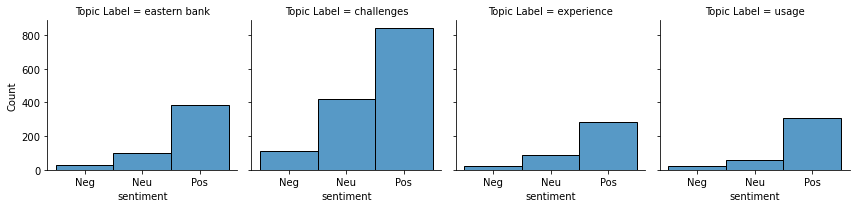

In [48]:
sns.displot(
    df, x="sentiment", col="Topic Label",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

In [ ]:
# you can select by topic too
# you'll need to maintain the oder of topic labels, etc. or just do the dtm
# the dtm was created in the earlier step, you can create a new one based on slicing the above dataframe

cv.vocabulary_

In [ ]:
# get the phrases from the dtm 
sum_words = dtm.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print (words_freq[:100])

In [ ]:
# set the stopwords list

stopwords = set(STOPWORDS)

In [ ]:
# Generating wordcloud and saving as jpg image
plt.figure(figsize=(14,10))

words_dict = dict(words_freq)
WC_height = 1000
WC_width = 1500
WC_max_words = 500
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width,stopwords=stopwords)
wordCloud.generate_from_frequencies(words_dict)
plt.title('Most frequently occurring bigrams connected by same colour and font size')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# save to file
# wordCloud.to_file('wordcloud_bigram.jpg')

# Topic Plot

In [ ]:
 # Generate the TF-IDF vectors
# this is the same step as earlier with the count vectorizer
vectorizer_tfidf = TfidfVectorizer(max_features=10000, ngram_range = (2,2))
vectors_tfidf = vectorizer_tfidf.fit_transform(df.Comments)
print(vectors_tfidf.shape)

In [ ]:
# Generate the TF-IDF dimension reduction
embedding_tfidf = umap.UMAP(random_state=SEED).fit_transform(vectors_tfidf)

In [ ]:
def enable_plotly_in_cell():
  import IPython
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

In [ ]:
# set up plotting

df['x'] = embedding_tfidf[:,0]
df['y'] = embedding_tfidf[:,1]

In [ ]:
df.head()

In [ ]:
# create a label from several text
# df['Label'] = (df['OS'] + " - Topic: " + df['Topic Label'] + '\n' + " - Comment: " + df['Comments'])
# df.head()


In [ ]:
# Wrap the text so it displays nicely in Plotly hover
df['wrap'] = df['Comments'].map(lambda x: '<br>'.join(textwrap.wrap(x, 64)))

In [ ]:
colors = ['purple', 'orange', 'blue', 'green']
topics = list(df['Topic Label'].unique())


enable_plotly_in_cell()

fig = go.Figure()


for i, topic in enumerate(topics):
    ix = df[df['Topic Label'] == topic]
    fig.add_trace(go.Scatter(x=ix.x,
                             y=ix.y,
                             name=topic,
                             showlegend=True,
                             mode='markers',
                             marker=dict(
                                 color=colors[i],
                                 size=4,
                                 opacity = 0.6)
                            ))


fig.update_traces(hovertemplate='OS: ' + df.OS + '<br>' + 'Topic: ' + df['Topic Label'] + '<br>' 
                  + df.wrap + '<extra></extra>')

   
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    hovermode="closest",
    title="Comment Clusters",
    legend_title_text='Topic',
    scene = dict(
        xaxis = dict(title=' ',visible=True, backgroundcolor="rgb(200, 200, 230)", tickvals=[]),
        yaxis = dict(title=' ',visible=True, backgroundcolor="rgb(200, 200, 230)", tickvals=[]),
    )
)


fig.update_layout(
    yaxis=dict(showticklabels=False),
    xaxis=dict(showticklabels=False)
)



 
    
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

    


iplot(fig)

# Deep Learning Model with GUSE
## Google Universal Sentence Encoder using Tensorflow

In [ ]:
# convert main text field to a list
# make each column a separate list

text = df['Comments'].to_list()
len(text)

In [ ]:
# get the sentences
# np_list = np.asarray(sentence_list) and then convert it to tensor using
# tensor_list = tf.convert_to_tensor(np_list)

np_list = np.asarray(text)
sentences = tf.convert_to_tensor(np_list)
sentences

In [ ]:
end = sentences.shape
end

In [ ]:
# encode them all
vectors_guse = guse(sentences)
print(vectors_guse.shape)

In [ ]:
# Generate the GUSE dimension reductions
embedding_guse = umap.UMAP(random_state=SEED, n_components = 2).fit_transform(vectors_guse)

In [ ]:
embedding_guse.shape

In [ ]:
# Wrap the text so it displays nicely in Plotly hover
df['wrap'] = df['Comments'].map(lambda x: '<br>'.join(textwrap.wrap(x, 64)))

In [ ]:
df['wrap'].iloc[0]

In [ ]:
df.head()

In [ ]:
df.to_csv('plotlyDemo.csv', index=False)

In [ ]:
df['wrap']

In [ ]:
# set up sentiment as z axis
df['x'] = embedding_guse[:,0]
df['y'] = embedding_guse[:,1]
df['z'] = df['compound']

In [ ]:
topics = list(df['Topic Label'].unique())
topics

In [ ]:
colors = ['purple', 'orange', 'blue', 'green']

In [ ]:
enable_plotly_in_cell()

fig = go.Figure()


for i, topic in enumerate(topics):
    ix = df[df['Topic Label'] == topic]
    fig.add_trace(go.Scatter3d(x=ix.x,
                               y=ix.y,
                               z=ix.compound,
                               name=topic,
                               showlegend=True,
                               mode='markers',
                               marker=dict(
                                   color=colors[i],
                                   size=4,
                                   opacity = 0.6,
                                   
                               )
                              ))


fig.update_traces(hovertemplate='OS: ' + df.OS + '<br>' + 'Topic: ' + df['Topic Label'] + '<br>' + 
                 'Sentiment: %{z:.2f}'+'<br>'+ df.wrap + '<extra></extra>')

   
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    hovermode="closest",
    title="Comment Clusters & Sentiment",
    legend_title_text='Topic',
    scene = dict(
        xaxis = dict(title=' ',visible=True, backgroundcolor="rgb(200, 200, 230)", tickvals=[]),
        yaxis = dict(title=' ',visible=True, backgroundcolor="rgb(200, 200, 230)", tickvals=[]),
        zaxis = dict(title='Sentiment',tickvals=[-1, -.75, -0.5, -0.25, 0, .25, 0.5,.75, 1.0])
    )
)
 
    
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=.8,
    xanchor="right",
    x=1
))

    


iplot(fig)